In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os


In [18]:
import pandas as pd

train_df = pd.read_excel("data/train.xlsx")
test_df = pd.read_excel("data/test2.xlsx")

print("Loaded train rows:", len(train_df))


Loaded train rows: 16209


## Exploratory and Geospatial Analysis

explaing how visual features effect prices

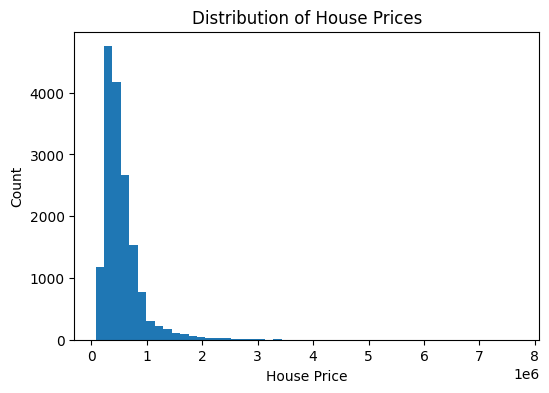

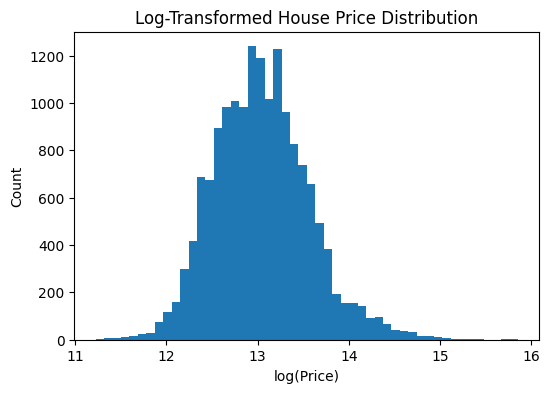

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(train_df["price"], bins=50)
plt.xlabel("House Price")
plt.ylabel("Count")
plt.title("Distribution of House Prices")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(np.log1p(train_df["price"]), bins=50)
plt.xlabel("log(Price)")
plt.ylabel("Count")
plt.title("Log-Transformed House Price Distribution")
plt.show()


The distribution of house prices is highly right-skewed, with a small number of
very high-priced properties. This motivates the use of a log transformation on
the target variable to stabilize variance and improve regression performance.

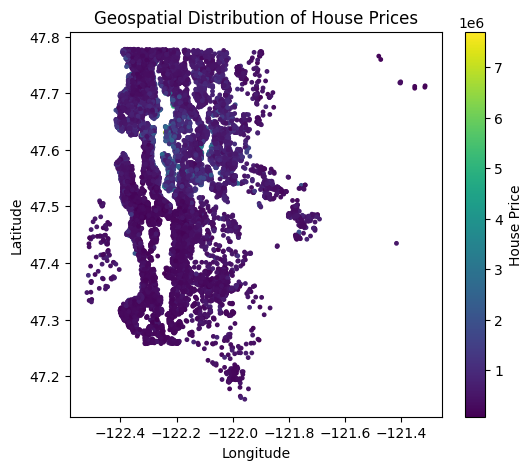

In [20]:
plt.figure(figsize=(6,5))
plt.scatter(
    train_df["long"],
    train_df["lat"],
    c=train_df["price"],
    cmap="viridis",
    s=6
)
plt.colorbar(label="House Price")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geospatial Distribution of House Prices")
plt.show()



The geospatial visualization reveals strong spatial clustering of property prices,
indicating that location plays a significant role in valuation. High-priced
properties tend to concentrate in specific geographic regions rather than being
uniformly distributed across the area.


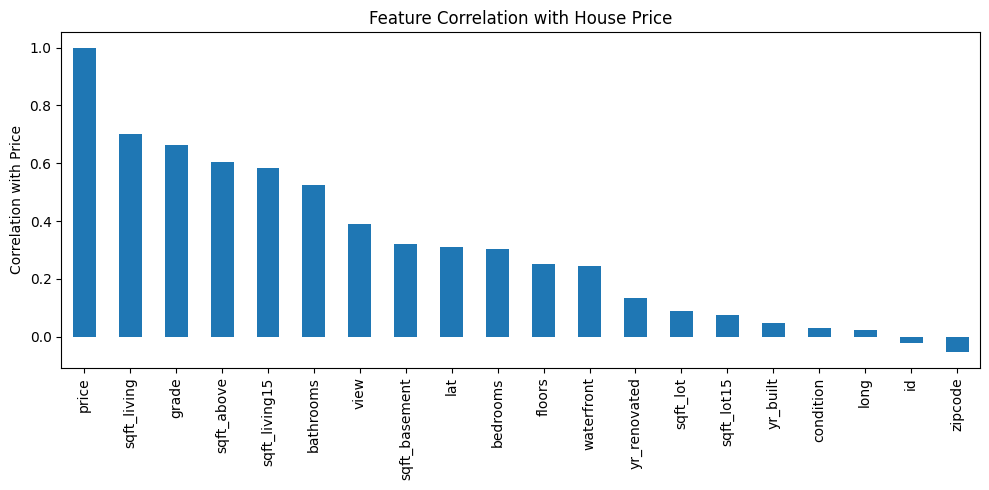

In [24]:
import matplotlib.pyplot as plt

corr = train_df.corr(numeric_only=True)["price"].sort_values(ascending=False)

plt.figure(figsize=(10,5))
corr.plot(kind="bar")
plt.ylabel("Correlation with Price")
plt.title("Feature Correlation with House Price")
plt.tight_layout()
plt.show()


The correlation analysis highlights that property size and construction quality
are the strongest drivers of price. Features such as `sqft_living`, `grade`,
`sqft_above`, and `bathrooms` exhibit high positive correlation with price.
Location-related attributes like latitude and waterfront presence also show
meaningful influence, reinforcing the importance of spatial context. Conversely,
identifier-based features such as `id` and `zipcode` show negligible correlation
and are excluded from modeling.


In [21]:
train_df.groupby("waterfront")["price"].mean()


waterfront
0    5.300675e+05
1    1.591938e+06
Name: price, dtype: float64

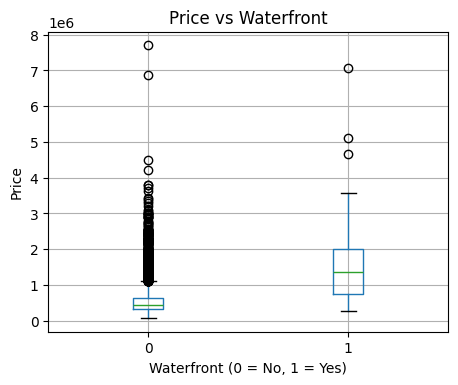

In [22]:
train_df.boxplot(column="price", by="waterfront", figsize=(5,4))
plt.title("Price vs Waterfront")
plt.suptitle("")
plt.xlabel("Waterfront (0 = No, 1 = Yes)")
plt.ylabel("Price")
plt.show()


Waterfront properties exhibit a substantially higher average price compared to
non-waterfront properties, confirming the premium associated with proximity to
water. This highlights the importance of environmental context in real estate
valuation

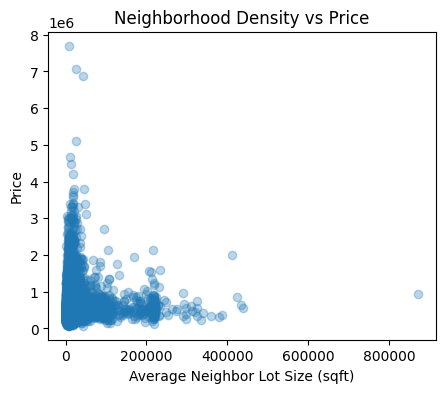

In [23]:
plt.figure(figsize=(5,4))
plt.scatter(
    train_df["sqft_lot15"],
    train_df["price"],
    alpha=0.3
)
plt.xlabel("Average Neighbor Lot Size (sqft)")
plt.ylabel("Price")
plt.title("Neighborhood Density vs Price")
plt.show()


Neighborhood density also shows a clear relationship with price. Areas with
larger average neighboring lot sizes generally correspond to higher property
values, reflecting differences between dense urban regions and lower-density
residential neighborhoods.


Overall, these findings demonstrate that spatial location, proximity to water,
and neighborhood characteristics significantly influence property prices.
Satellite imagery provides complementary visual cues for these spatial patterns,
which are learned automatically by the CNN-based image encoder in the multimodal
model.

## Data Cleaning and Feature Engineering


In [13]:
features = [
    "bedrooms","bathrooms","sqft_living","sqft_lot",
    "floors","waterfront","view","condition","grade",
    "sqft_above","sqft_basement","lat","long",
    "sqft_living15","sqft_lot15"
]

target = "price"


In [14]:
required_cols = features + [target, "id"]
train_df = train_df.dropna(subset=required_cols)
test_df = test_df.dropna(subset=features + ["id"])

print("After NaN cleaning:", len(train_df))


After NaN cleaning: 16209


In [15]:
def has_image(id_, split):
    return os.path.isfile(f"images/{split}/{id_}.0.png")

print("Before filter:", len(train_df))

train_df = train_df[train_df["id"].apply(lambda x: has_image(x,"train"))]
test_df  = test_df[test_df["id"].apply(lambda x: has_image(x,"test"))]

print("After filter:", len(train_df))


Before filter: 16209
After filter: 3040


In [25]:
X = train_df[features].values
y = np.log1p(train_df[target].values)

X_test = test_df[features].values


In [26]:
print(X.shape)
print(y.shape)
print(X_test.shape)

assert X.shape[0] == y.shape[0]
assert X.shape[0] == len(train_df)


(3040, 15)
(3040,)
(3004, 15)


In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val, train_ids, val_ids = train_test_split(
    X,
    y,
    train_df["id"].values,
    test_size=0.2,
    random_state=42
)

print("Train set:", X_train.shape, X_val.shape)

Train set: (2432, 15) (608, 15)


In [32]:
import numpy as np

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)

np.save("train_ids.npy", train_ids)
np.save("val_ids.npy", val_ids)

np.save("X_test.npy", X_test)
np.save("test_ids.npy", test_df["id"].values)


In [31]:
pd.DataFrame(X_train, columns=features).to_csv("train_clean.csv", index=False)
pd.DataFrame(X_test, columns=features).to_csv("test_clean.csv", index=False)
